Deep Learning Project, Captcha-Recognition, Dec-2024 - Jan-2025, Guyon Thomas & Poberay Bastien, Centrale Lille

# Introduction

## History of CAPTCHA

CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) was introduced in the early 2000s as a way to prevent automated bots from accessing certain online services. The idea was to create tasks that are easy for humans to solve but difficult for machines. Early CAPTCHAs often involved distorted text that users had to recognize and type in.

Over time, as machine learning and AI technologies advanced, traditional text-based CAPTCHAs became less effective. Bots became capable of solving these CAPTCHAs with high accuracy. This led to the development of more complex CAPTCHAs, such as image-based challenges (e.g., selecting all images containing a certain object) and behavioral analysis (e.g., tracking mouse movements).

The purpose of this notebook is to explore an old dataset of captcha (https://www.kaggle.com/datasets/fournierp/captcha-version-2-images) and try to implement various models seen in class.Also, we will try to implement more advanced models such as a multi-output model (CNN with 5 branches), and a CNN-RNN combined with a custom loss function called Connectionist Temporal Classification (CTC).

Number of images : 1070
Image dimensions : (50, 200)
Label length : 5
samples\226md.png


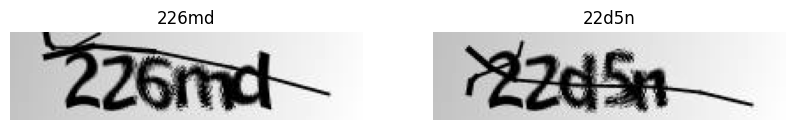

In [ ]:
import os
import numpy as np
import cv2
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
from sklearn.utils import shuffle
from tensorflow.keras import models
import pandas as pd

# Define the folder path
folder_path = "samples"

# Init main values
symbols = "0123456789" + string.ascii_lowercase  # All symbols captcha can contain
num_symbols = len(symbols)

# Captcha max length
max_length = 5

# image dimensions
img_width = 200
img_height = 50
img_shape = (img_height, img_width, 1)

images = []
images_paths = []
labels = []

# Load images and labels
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load image
        img = cv2.imread(os.path.join(folder_path, filename))
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Append to lists
        images_paths.append(os.path.join(folder_path, filename))
        images.append(gray_img)
        labels.append(os.path.splitext(filename)[0])

# Display two images with their labels
plt.figure(figsize=(10, 5))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")

print(f"Number of images : {len(images)}")
print(f"Image dimensions : {images[0].shape}")
print(f"Label length : {len(labels[0])}")
print(images_paths[0])
plt.show()

In [2]:
nb_epoch = 25
batch_size = 16

# Prepare Data

In [3]:
# Create one-hot encoded matrix for labels
# Each label has 5 characters, and each character can be one of the symbols
label_length = 5
n_samples = len(labels)
one_hot_labels = np.zeros((n_samples, label_length, num_symbols))

# Fill the one-hot encoded matrix
for i, label in enumerate(labels):
    for j, char in enumerate(label):
        char_index = symbols.find(char)
        one_hot_labels[i, j, char_index] = 1

# Verify the shape of the encoded labels
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")
print(f"Possible characters : {list(symbols)}")
print(f"Example of first label '{labels[0]}' encoded:")
for j in range(label_length):
    char_index = np.where(one_hot_labels[0, j] == 1)[0][0]
    print(f"Position {j}: {symbols[char_index]} -> {one_hot_labels[0, j]}")

One-hot encoded labels shape: (1070, 5, 36)
Possible characters : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Example of first label '226md' encoded:
Position 0: 2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 1: 2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 2: 6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 3: m -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Position 4: d -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# Convert list of images to numpy array and normalize
X = np.array(images) / 255.0
X = np.expand_dims(X, axis=-1)  # Add channel dimension

# Reshape y to match the expected format (n_samples, 5, num_symbols)
y = one_hot_labels

# Get shuffled indices
indices = np.arange(len(X))
np.random.shuffle(indices)

# Shuffle X, y, labels and images_paths
X = np.transpose(X, (0, 2, 1, 3))  # Transpose before shuffling
X = X[indices]
y = y[indices]
labels = np.array(labels)[indices]
images_paths = np.array(images_paths)[indices]

# Split ratios (90% train, 5% validation, 5% test)
train_size = int(0.90 * len(X))
val_size = int(0.05 * len(X))

# Split the data
X_train = X[:train_size]
y_train = y[:train_size]
labels_train = labels[:train_size]
images_paths_train = images_paths[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]
labels_val = labels[train_size : train_size + val_size]
images_paths_val = images_paths[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]
labels_test = labels[train_size + val_size :]
images_paths_test = images_paths[train_size + val_size :]

print("X : (n_samples, width, height, channels)")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print("\ny : (n_samples, label_length, num_symbols)")
print(f"Train label vector shape: {y_train.shape}")
print(f"Validation label vector shape: {y_val.shape}")
print(f"Test label vector shape: {y_test.shape}")
print("\nLabels : (n_samples)")
print(f"Train labels shape: {labels_train.shape}")
print(f"Validation labels shape: {labels_val.shape}")
print(f"Test labels shape: {labels_test.shape}")
print("\nPaths : (n_samples)")
print(f"Train paths shape: {images_paths_train.shape}")
print(f"Validation paths shape: {images_paths_val.shape}")
print(f"Test paths shape: {images_paths_test.shape}")

X : (n_samples, width, height, channels)
Training set shape: (963, 200, 50, 1)
Validation set shape: (53, 200, 50, 1)
Test set shape: (54, 200, 50, 1)

y : (n_samples, label_length, num_symbols)
Train label vector shape: (963, 5, 36)
Validation label vector shape: (53, 5, 36)
Test label vector shape: (54, 5, 36)

Labels : (n_samples)
Train labels shape: (963,)
Validation labels shape: (53,)
Test labels shape: (54,)

Paths : (n_samples)
Train paths shape: (963,)
Validation paths shape: (53,)
Test paths shape: (54,)


# Function to visualize / evaluate models

In [5]:
def evaluate_predictions(model, X_test, y_test, symbols, num_samples=20):
    plt.figure(figsize=(20, 10))
    correct_predictions = 0
    total_chars = num_samples * 5  # 5 characters per sample
    complete_correct = 0

    for i in range(num_samples):

        # Get prediction for single image
        pred = model.predict(X_test[i : i + 1], verbose=0)
        pred_indices = [np.argmax(pred[0, j]) for j in range(5)]
        pred_text = "".join([symbols[j] for j in pred_indices])

        # Get true label
        true_indices = [np.argmax(y_test[i, j]) for j in range(5)]
        true_text = "".join([symbols[j] for j in true_indices])

        # Count correct characters
        correct_predictions += sum(1 for p, t in zip(pred_text, true_text) if p == t)

        # Count correct captcha completions
        if pred_text == true_text:
            complete_correct += 1

        # Display result
        plt.subplot(4, 5, i + 1)
        plt.imshow(X_test[i].T.squeeze(), cmap="gray")
        plt.title(
            f"Pred : {pred_text}",
            color="green" if pred_text == true_text else "red",
            fontsize=10,
        )
        plt.axis("off")

    # Show accuracy
    accuracy = correct_predictions / total_chars
    print(f"Character-level accuracy: {accuracy:.2%}")
    completion_rate = complete_correct / num_samples
    print(f"Complete captcha success rate: {completion_rate:.2%}")
    plt.tight_layout()
    plt.show()
    return accuracy, completion_rate

In [6]:
def evaluate_predictions_multi_output(model, X_test, y_test, symbols, num_samples=20):
    plt.figure(figsize=(20, 10))
    correct_predictions = 0
    total_chars = num_samples * 5  # 5 characters per sample
    complete_correct = 0

    for i in range(num_samples):
        # Get predictions for single image
        preds = model.predict(
            X_test[i : i + 1], verbose=0
        )  # Returns list of 5 predictions

        # Get predicted indices for each character
        pred_indices = [np.argmax(preds[j][0]) for j in range(5)]
        pred_text = "".join([symbols[j] for j in pred_indices])

        # Get true labels
        true_indices = [
            np.argmax(y_test[i, j, :]) for j in range(5)
        ]  # Changed indexing
        true_text = "".join([symbols[j] for j in true_indices])

        # Count correct characters
        correct_predictions += sum(1 for p, t in zip(pred_text, true_text) if p == t)

        # Count complete correct predictions
        if pred_text == true_text:
            complete_correct += 1

        # Display result - transpose the image back to (50,200,1) for display
        display_img = np.transpose(X_test[i], (1, 0, 2))
        plt.subplot(4, 5, i + 1)
        plt.imshow(display_img.squeeze(), cmap="gray")
        plt.title(
            f"True: {true_text}\nPred: {pred_text}",
            color="green" if pred_text == true_text else "red",
            fontsize=10,
        )
        plt.axis("off")

    # Show accuracy metrics
    accuracy = correct_predictions / total_chars
    print(f"Character-level accuracy: {accuracy:.2%}")
    completion_rate = complete_correct / num_samples
    print(f"Complete captcha success rate: {completion_rate:.2%}")
    plt.tight_layout()
    plt.show()
    return accuracy, completion_rate

___

# Single output of size 5

## CNN

In [7]:
def create_cnn_model(img_shape=(200, 50, 1), num_symbols=36):
    # Input layer
    img = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(32, (3, 3), activation="relu")(img)
    mp1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(mp1)
    mp2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(128, (3, 3), activation="relu")(mp2)
    mp3 = layers.MaxPooling2D((2, 2))(conv3)

    # Flatten the output
    flat = layers.Flatten()(mp3)  # Flatten to 1D vector

    # Fully connected layers
    dens1 = layers.Dense(128, activation="relu")(flat)  # Fully connected layer

    # Output layer for 5 characters
    output = layers.Dense(5 * num_symbols, activation="softmax")(
        dens1
    )  # 5 * 36 outputs
    output = layers.Reshape((5, num_symbols))(output)

    # Define the model
    model = models.Model(img, output)

    # Compile the model
    model.compile(
        optimizer="adam",  # Optimizer
        loss="categorical_crossentropy",  # Loss
        metrics=["accuracy"],  # Accuracy
    )

    return model


# Create the model
cnn_model = create_cnn_model()

# Summary
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 48, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 9, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 180)            │        23,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,623,348 (6.19 MB)

 Trainable params: 1,623,348 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = cnn_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0683 - loss: 3.3184
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1010 - loss: 2.9100
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3109 - loss: 2.3131
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5811 - loss: 1.3924
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7472 - loss: 0.8039
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8455 - loss: 0.4938
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9152 - loss: 0.2628
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9369 - loss: 0.1872
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9381 - loss: 0.1778
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9607 - loss: 0.1159
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9888 - loss: 0.0454
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy:

Character-level accuracy: 76.00%
Complete captcha success rate: 20.00%


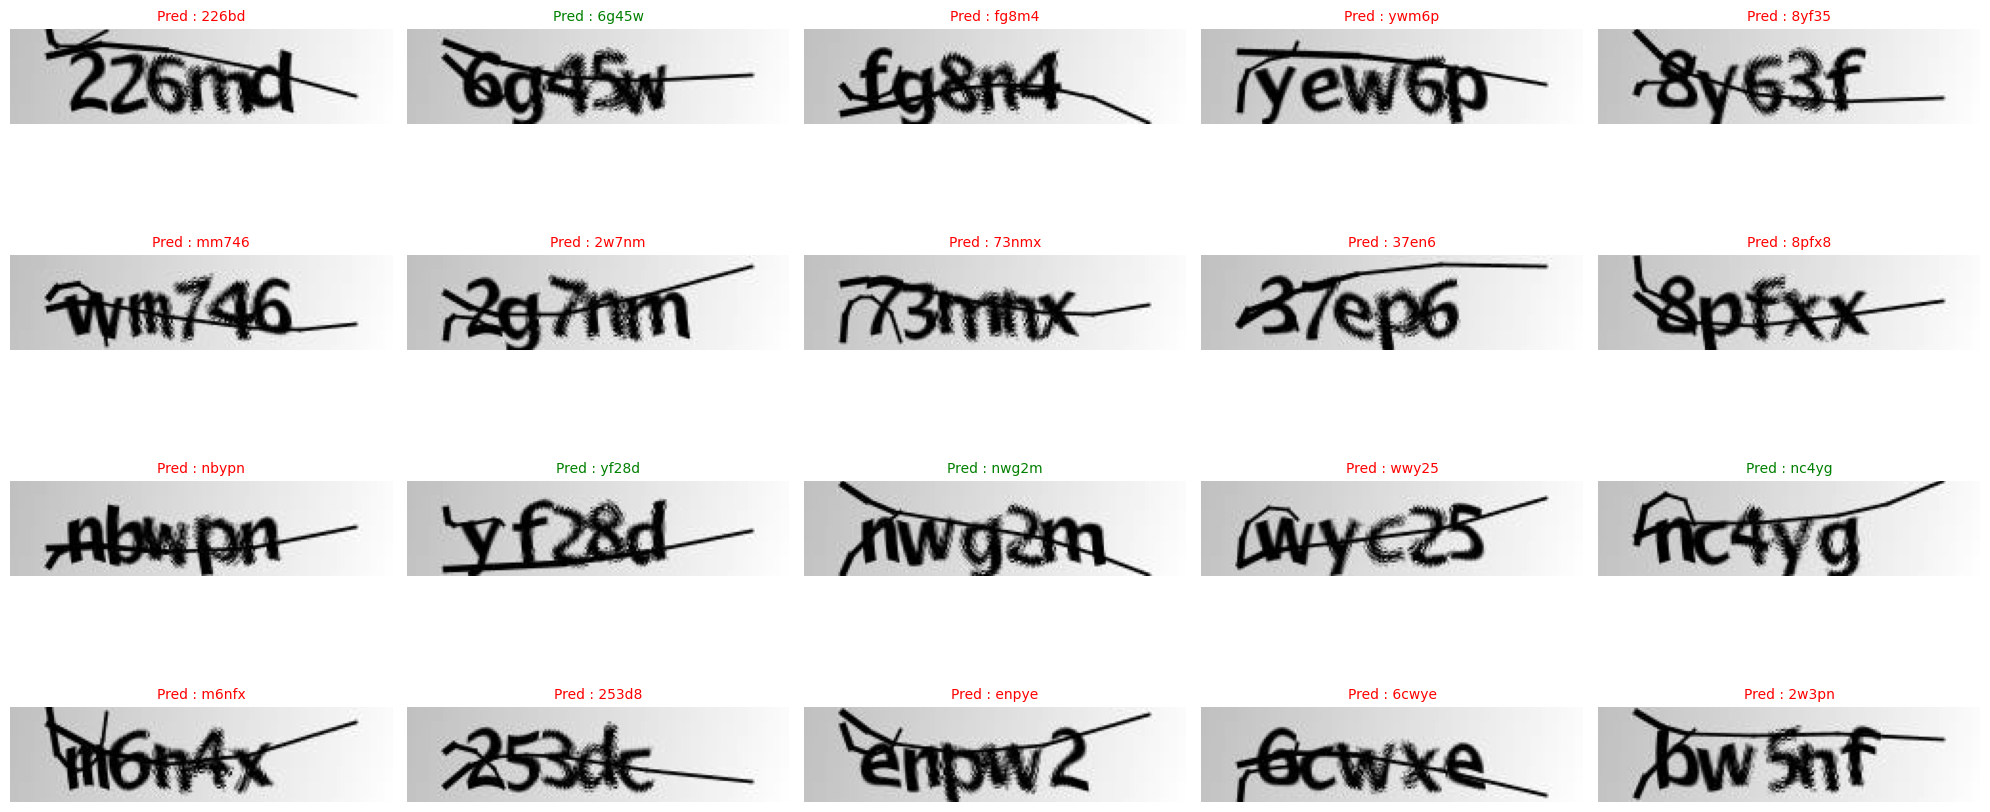

In [9]:
# Evaluate CNN model
cnn_a, cnn_cr = evaluate_predictions(cnn_model, X_test, y_test, symbols)

## CNN-LSTM

In [10]:
def create_cnn_lstm_model(img_shape=(200, 50, 1), num_symbols=36):
    # Input layer
    img = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(img)
    mp1 = layers.MaxPooling2D(padding="same")(conv1)
    conv2 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(mp1)
    mp2 = layers.MaxPooling2D(padding="same")(conv2)
    conv3 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding="same")(bn)

    # TimeDistributed Flatten
    flat = layers.TimeDistributed(layers.Flatten())(mp3)  # Flatten each time step

    # LSTM layer
    lstm = layers.LSTM(128, return_sequences=True)(flat)  # LSTM layer

    # TimeDistributed Dense layer for character prediction
    dense = layers.TimeDistributed(layers.Dense(num_symbols, activation="softmax"))(
        lstm
    )

    # Ensure output has exactly 5 timesteps
    output = layers.Lambda(lambda x: x[:, :5, :])(dense)

    # Define the model
    model = models.Model(img, output)

    # Compile the model
    model.compile(
        optimizer="adam",  # Optimizer
        loss="categorical_crossentropy",  # Loss
        metrics=["accuracy"],  # Accuracy
    )

    return model


# Create the model
cnn_lstm_model = create_cnn_lstm_model()

# Summary
cnn_lstm_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 13, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 25, 224)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25, 128)        │       180,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 25, 36)         │         4,644 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,788 (870.27 KB)

 Trainable params: 222,724 (870.02 KB)

 Non-trainable params: 64 (256.00 B)

In [11]:
cnn_lstm_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch * 2,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.0807 - loss: 3.1523 - val_accuracy: 0.0792 - val_loss: 3.0308
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1001 - loss: 2.9429 - val_accuracy: 0.0792 - val_loss: 2.9992
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1039 - loss: 2.9320 - val_accuracy: 0.0792 - val_loss: 2.9908
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1082 - loss: 2.9221 - val_accuracy: 0.0792 - val_loss: 2.9760
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1055 - loss: 2.9117 - val_accuracy: 0.0792 - val_loss: 2.9610
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.0977 - loss: 2.9106 - val_accuracy: 0.0792 - val_loss: 2.9709
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0983 - loss: 2.9012 - val_accuracy: 0.0717 - val_loss: 2.9797
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1129 - loss: 2.8936 - val_accuracy: 0.0792 - v

Character-level accuracy: 7.00%
Complete captcha success rate: 0.00%


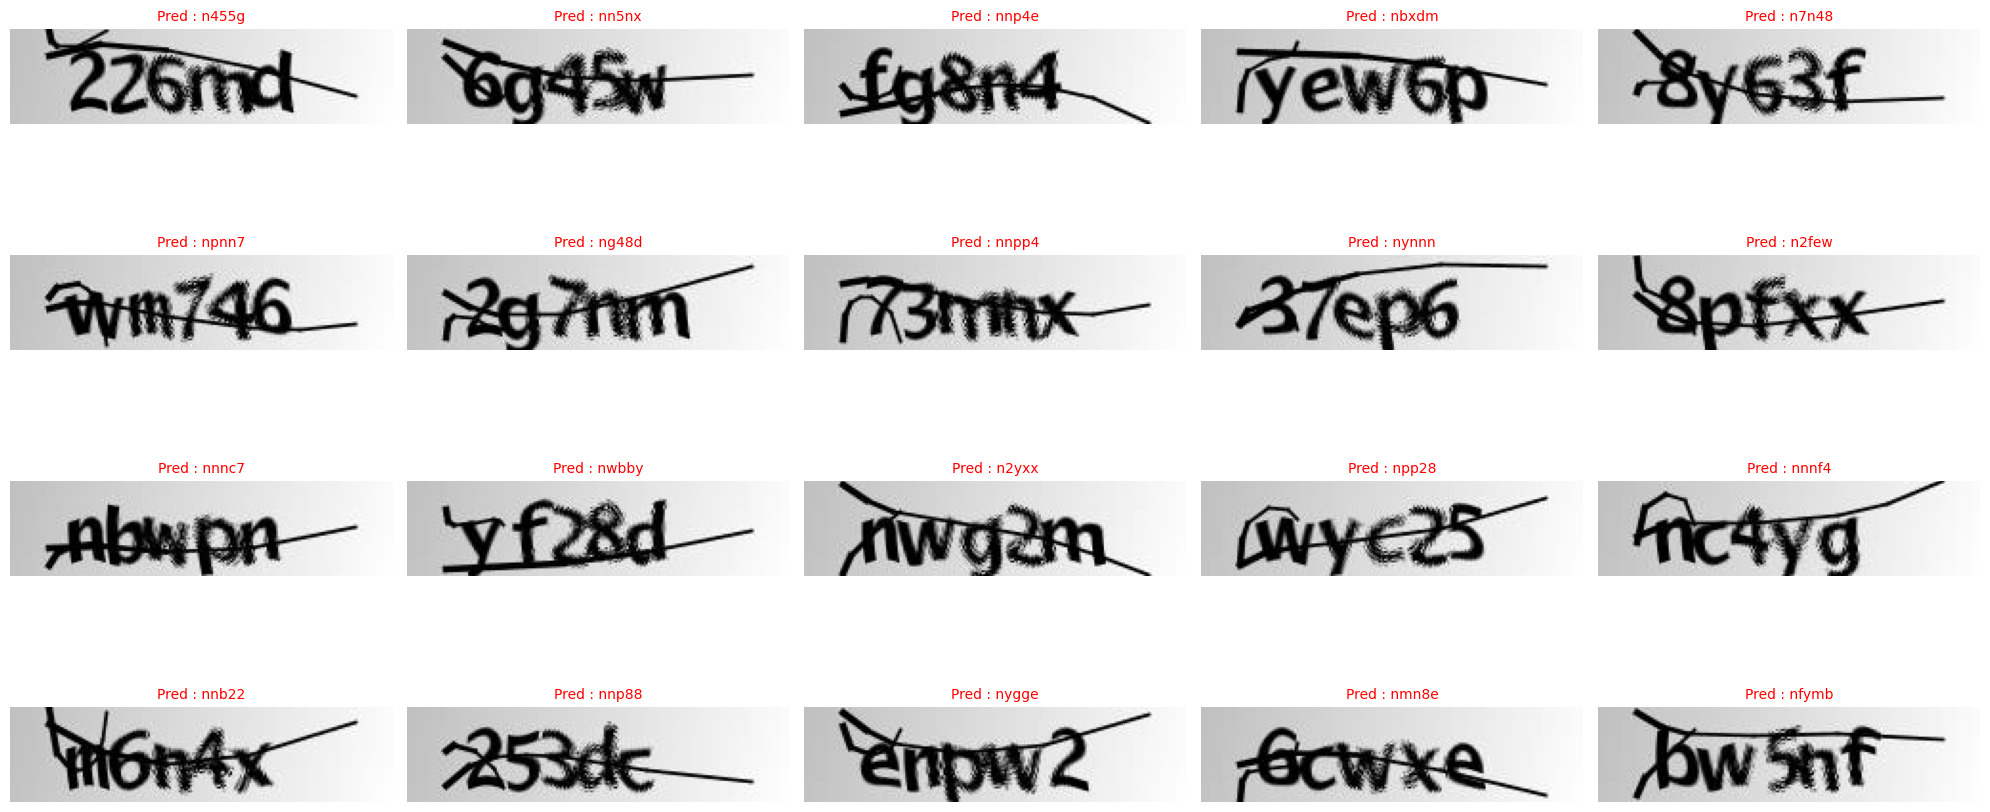

In [12]:
# Evaluate CNN+LSTM model
cnn_lstm_a, cnn_lstm_cr = evaluate_predictions(cnn_lstm_model, X_test, y_test, symbols)

## CRNN

In [13]:
def create_crnn_model(img_shape=(200, 50, 1), num_symbols=36):
    # Input layer
    img = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(32, (3, 3), activation="relu")(img)
    mp1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(mp1)
    mp2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(32, (3, 3), activation="relu")(mp2)
    mp3 = layers.MaxPooling2D((2, 2))(conv3)

    # Reshape for RNN
    reshape = layers.Reshape((-1, 128))(mp3)

    # Bidirectional LSTM
    lstm = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(reshape)

    # TimeDistributed Dense layer for character prediction
    dense = layers.TimeDistributed(layers.Dense(num_symbols, activation="softmax"))(
        lstm
    )

    # Ensure output has exactly 5 timesteps
    output = layers.Lambda(lambda x: x[:, :5, :])(dense)

    # Define the model
    model = models.Model(img, output)

    # Compile the model
    model.compile(
        optimizer="adam",  # Optimizer
        loss="categorical_crossentropy",  # Loss
        metrics=["accuracy"],  # Accuracy
    )

    return model


# Create the model
crnn_model = create_crnn_model()

# Summary
crnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 198, 48, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 99, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 97, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 48, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 46, 9, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 23, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 23, 36)         │         9,252 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 309,700 (1.18 MB)

 Trainable params: 309,700 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
crnn_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch * 2,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.0754 - loss: 3.1508 - val_accuracy: 0.0792 - val_loss: 2.9809
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1056 - loss: 2.9500 - val_accuracy: 0.0792 - val_loss: 2.9810
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1022 - loss: 2.9382 - val_accuracy: 0.0792 - val_loss: 2.9678
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1036 - loss: 2.9414 - val_accuracy: 0.0792 - val_loss: 2.9646
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1051 - loss: 2.9297 - val_accuracy: 0.0792 - val_loss: 2.9551
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0987 - loss: 2.9387 - val_accuracy: 0.0792 - val_loss: 2.9608
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0977 - loss: 2.9375 - val_accuracy: 0.0792 - val_loss: 2.9501
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.1032 - loss: 2.9334 - val_accuracy: 0.0792 - v

Character-level accuracy: 39.00%
Complete captcha success rate: 0.00%


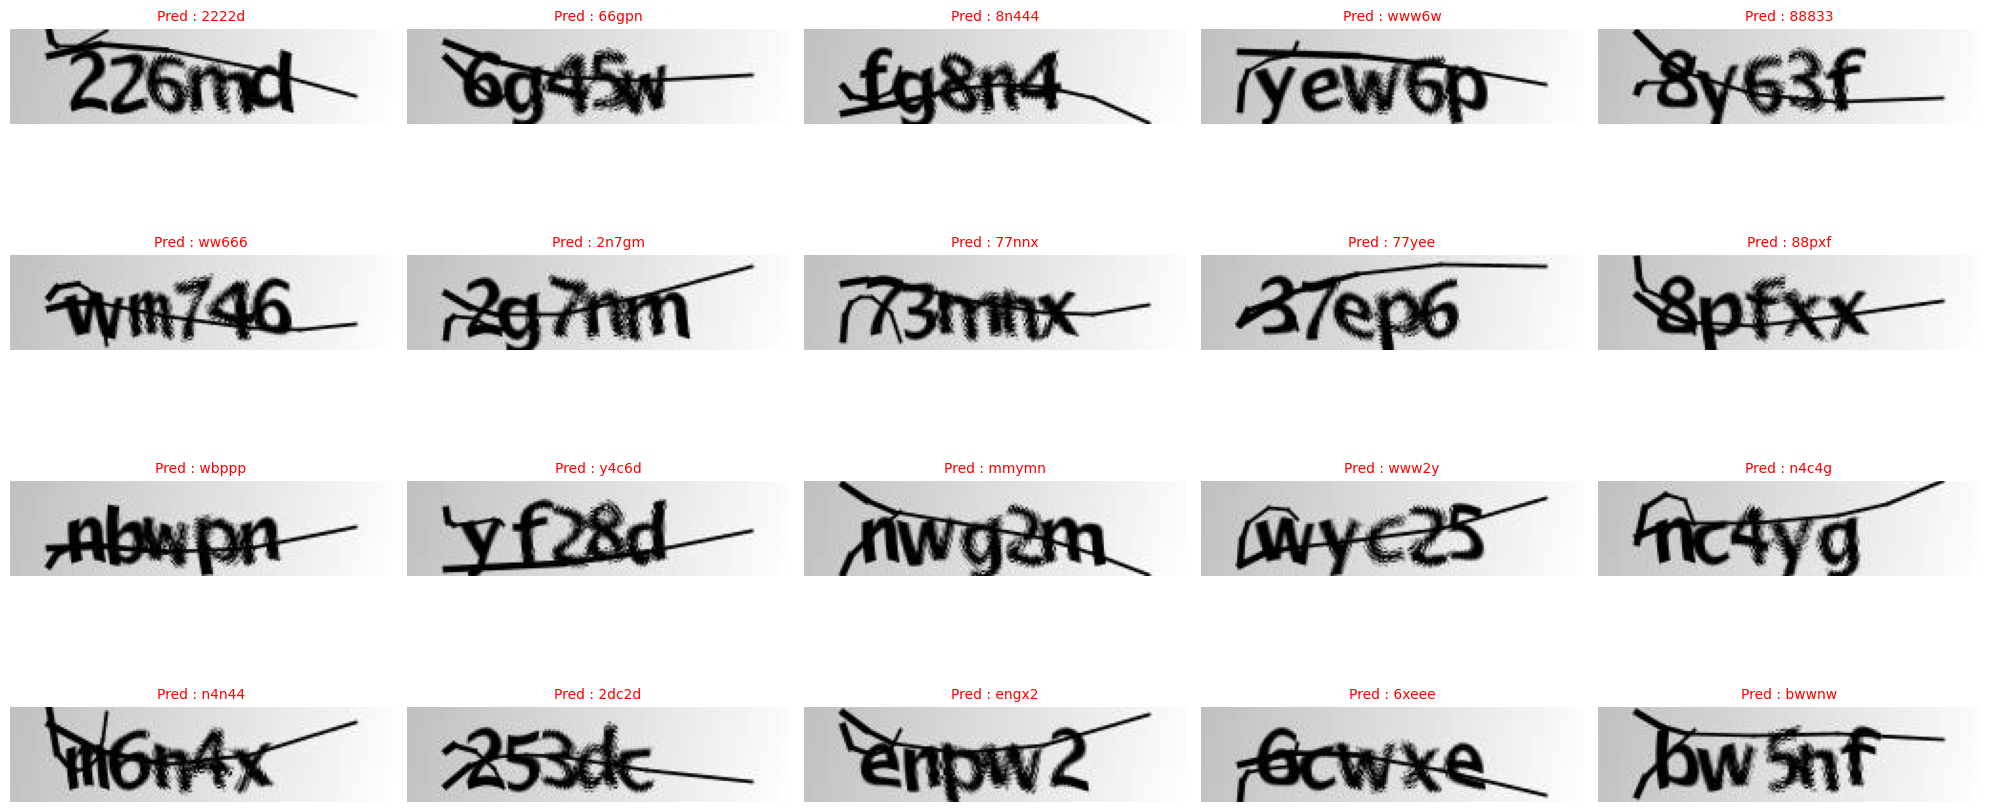

In [15]:
# Evaluate CRNN model
crnn_a, crnn_cr = evaluate_predictions(crnn_model, X_test, y_test, symbols)

## Transformer

In [16]:
# Define the Transformer encoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Define the model
def create_transformer_model(img_shape=(200, 50, 1), num_symbols=36):
    # Input layer
    inputs = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    mp1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(mp1)
    mp2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(128, (3, 3), activation="relu")(mp2)
    mp3 = layers.MaxPooling2D((2, 2))(conv3)

    # Reshape for Transformer
    reshape = layers.Reshape((-1, 256))(mp3)

    # Transformer Encoder
    transformer = TransformerEncoder(embed_dim=256, num_heads=4, ff_dim=256)(
        reshape, training=False
    )

    # Global Average Pooling
    gap = layers.GlobalAveragePooling1D()(transformer)

    # Output layer for 5 characters
    dense = layers.Dense(5 * num_symbols, activation="softmax")(gap)
    outputs = layers.Reshape((5, num_symbols))(dense)

    # Define the model
    model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer="adam",  # Optimizer
        loss="categorical_crossentropy",  # Loss
        metrics=["accuracy"],  # Accuracy
    )

    return model


# Create the model
transformer_model = create_transformer_model()

# Summary
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 198, 48, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 99, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 97, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 48, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 46, 9, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 23, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 46, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 46, 256)        │     1,184,512 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 180)            │        46,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,323,444 (5.05 MB)

 Trainable params: 1,323,444 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
transformer_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch * 2,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.0729 - loss: 3.3277 - val_accuracy: 0.0679 - val_loss: 3.0770
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.0678 - loss: 2.9998 - val_accuracy: 0.0717 - val_loss: 3.0725
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0663 - loss: 3.0033 - val_accuracy: 0.0604 - val_loss: 2.9955
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.0759 - loss: 2.9879 - val_accuracy: 0.0340 - val_loss: 3.0412
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.0785 - loss: 2.9837 - val_accuracy: 0.0717 - val_loss: 3.0432
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0862 - loss: 2.9868 - val_accuracy: 0.0792 - val_loss: 2.9948
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0709 - loss: 2.9788 - val_accuracy: 0.0792 - val_loss: 3.0330
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0849 - loss: 2.9605 - val_accuracy: 0.0792 - v

Character-level accuracy: 36.00%
Complete captcha success rate: 0.00%


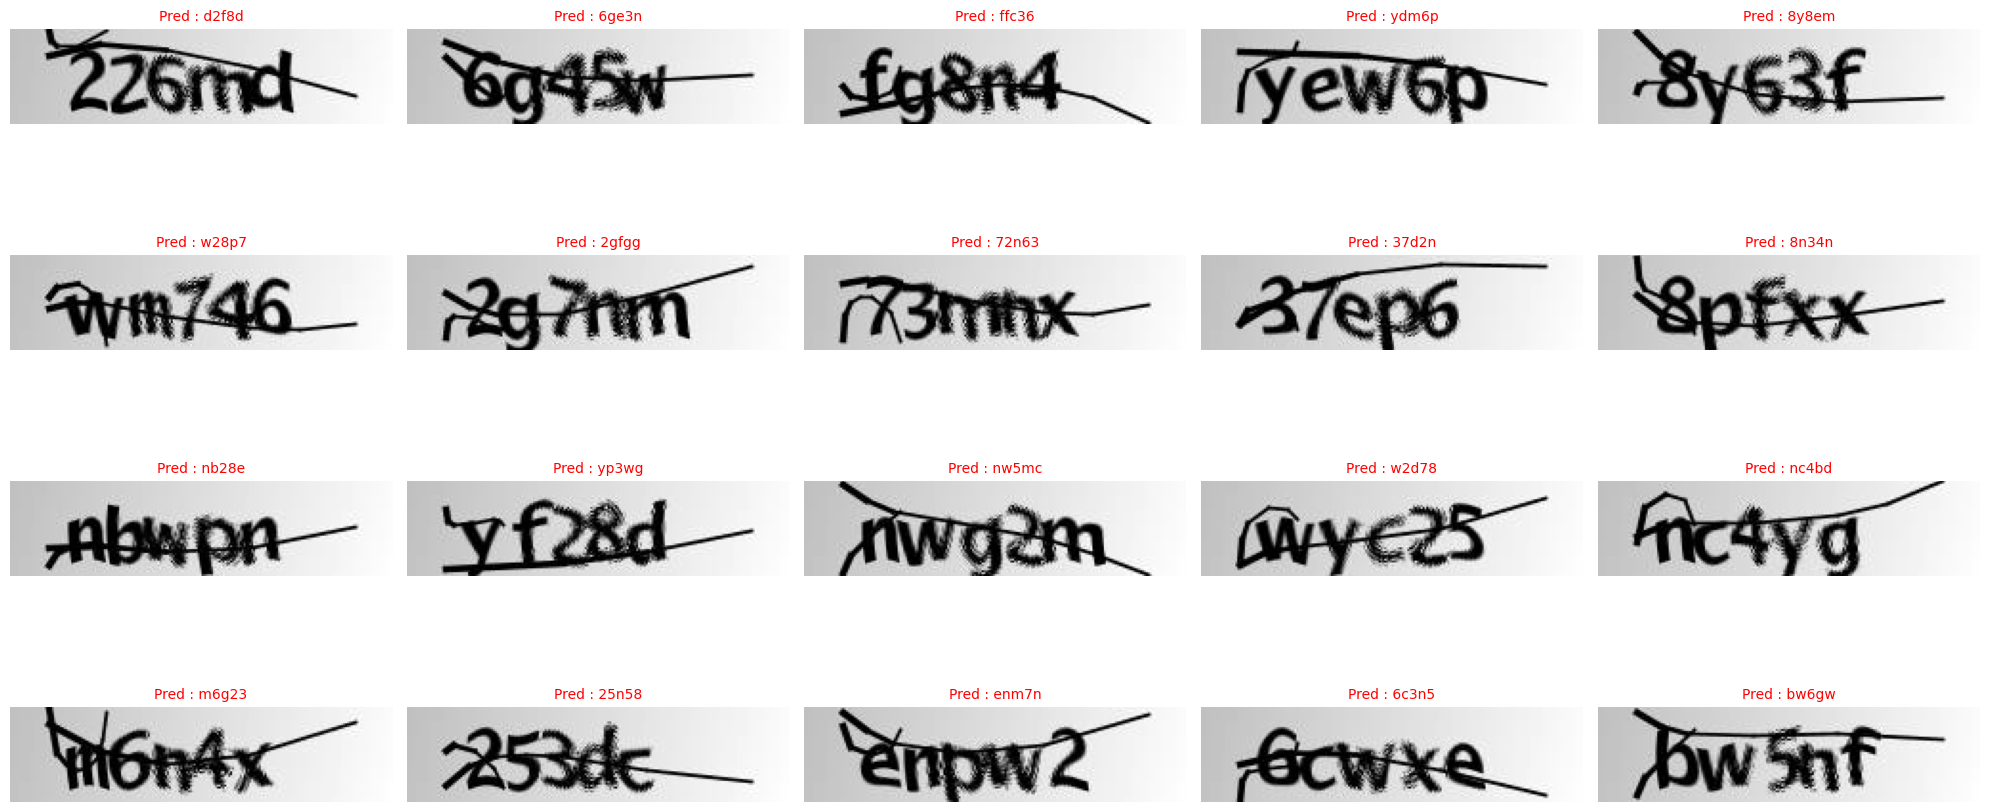

In [18]:
# Evaluate Transformer model
transformer_a, transformer_cr = evaluate_predictions(
    transformer_model, X_test, y_test, symbols
)

## CNN with Attention

In [19]:
# Define the attention layer
class AttentionLayer(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], 1), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        attention_weights = tf.nn.softmax(
            tf.matmul(inputs, self.W), axis=1
        )  # Shape: (batch_size, timesteps, 1)
        weighted_inputs = (
            inputs * attention_weights
        )  # Shape: (batch_size, timesteps, features)
        return tf.reduce_sum(weighted_inputs, axis=1)  # Shape: (batch_size, features)


# Define the model
def create_cnn_attention_model(img_shape=(200, 50, 1), num_symbols=36):
    # Input layer
    inputs = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(64, (3, 3), activation="relu")(inputs)
    mp1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = layers.Conv2D(32, (3, 3), activation="relu")(mp1)
    mp2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = layers.Conv2D(128, (3, 3), activation="relu")(mp2)
    mp3 = layers.MaxPooling2D((2, 2))(conv3)
    conv4 = layers.Conv2D(256, (3, 3), activation="relu")(mp3)
    mp4 = layers.MaxPooling2D((2, 2))(conv4)

    # Flatten the output
    flat = layers.Flatten()(mp4)

    # Reshape for attention
    reshape = layers.Reshape((-1, 512))(flat)

    # Attention layer
    attention = AttentionLayer()(reshape)

    # Output layer for 5 characters
    dense = layers.Dense(5 * num_symbols, activation="softmax")(attention)
    outputs = layers.Reshape((5, num_symbols))(dense)

    # Define the model
    model = models.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer="adam",  # Optimizer
        loss="categorical_crossentropy",  # Loss
        metrics=["accuracy"],  # Accuracy
    )

    return model


# Create the model
cnn_attention_model = create_cnn_attention_model()

# Summary
cnn_attention_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 198, 48, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 99, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 97, 22, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 48, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 46, 9, 128)     │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 23, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 21, 2, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 5, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 512)            │           512 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 180)            │        92,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,116 (1.69 MB)

 Trainable params: 444,116 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
cnn_attention_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.0642 - loss: 3.2360 - val_accuracy: 0.0792 - val_loss: 2.9856
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0962 - loss: 2.9632 - val_accuracy: 0.0830 - val_loss: 2.9732
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1003 - loss: 2.9465 - val_accuracy: 0.0566 - val_loss: 2.9692
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0942 - loss: 2.9416 - val_accuracy: 0.0792 - val_loss: 2.9532
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.1067 - loss: 2.9127 - val_accuracy: 0.1547 - val_loss: 2.8986
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1658 - loss: 2.7647 - val_accuracy: 0.1774 - val_loss: 2.7517
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2531 - loss: 2.4867 - val_accuracy: 0.2340 - val_loss: 2.5692
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3277 - loss: 2.2173 - val_accuracy: 0.2755 - v

Character-level accuracy: 51.00%
Complete captcha success rate: 0.00%


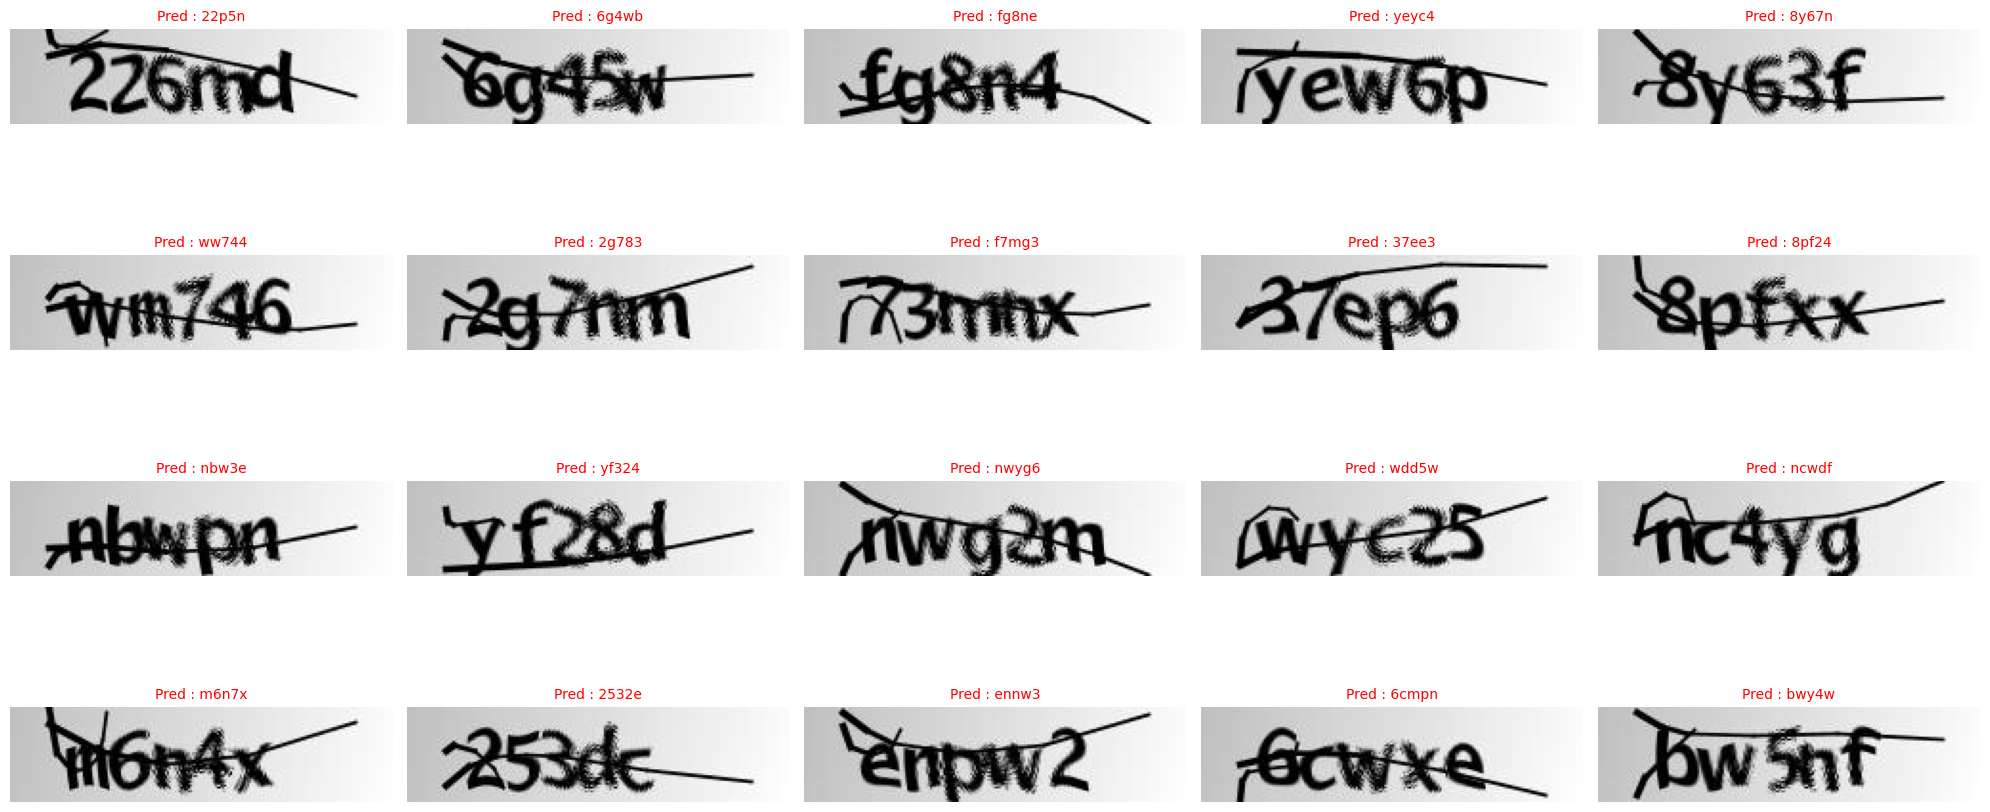

In [21]:
# Evaluate CNN with Attention model
att_cnn_a, att_cnn_cr = evaluate_predictions(
    cnn_attention_model, X_test, y_test, symbols
)

___

# CTC Loss function for a CNN-RNN-CTC model

Factor by which the image is going to be downsampled by the convolutional blocks.  
We will be using two convolution blocks and each block will have a pooling layer which downsample the features by a factor of 2.  
Hence total downsampling factor would be 4.

In [22]:
downsample_factor = 4
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))
print(list(characters))

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [23]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = ops.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


train_dataset = tf.data.Dataset.from_tensor_slices((images_paths_train, labels_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((images_paths_val, labels_val))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## CTC part

In [24]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64"),
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [25]:
def build_ctc_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
ctc_model = build_ctc_model()
ctc_model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 256)   │    197,632 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 128)   │    164,352 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 21)    │      2,709 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 21)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the ctc_model
history = ctc_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=nb_epoch * 4,
    callbacks=[early_stopping],
)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 494.9907 - val_loss: 248.1600
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 262.6651 - val_loss: 247.7458
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 262.4009 - val_loss: 247.6140
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 262.1215 - val_loss: 247.3609
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 262.0893 - val_loss: 247.4082
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 261.9427 - val_loss: 247.1977
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 261.6804 - val_loss: 247.1497
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 261.7033 - val_loss: 247.1440
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 261.6603 - val_loss: 246.9608
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 261.6877 - val_loss: 246.6938
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 261.5045 - val_loss: 246.4293
Epoch 1

In [27]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_ctc_model = keras.models.Model(
    ctc_model.input[0], ctc_model.get_layer(name="dense2").output
)
prediction_ctc_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 21)         │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
Character-level accuracy: 100.00%
Complete captcha success rate: 100.00%


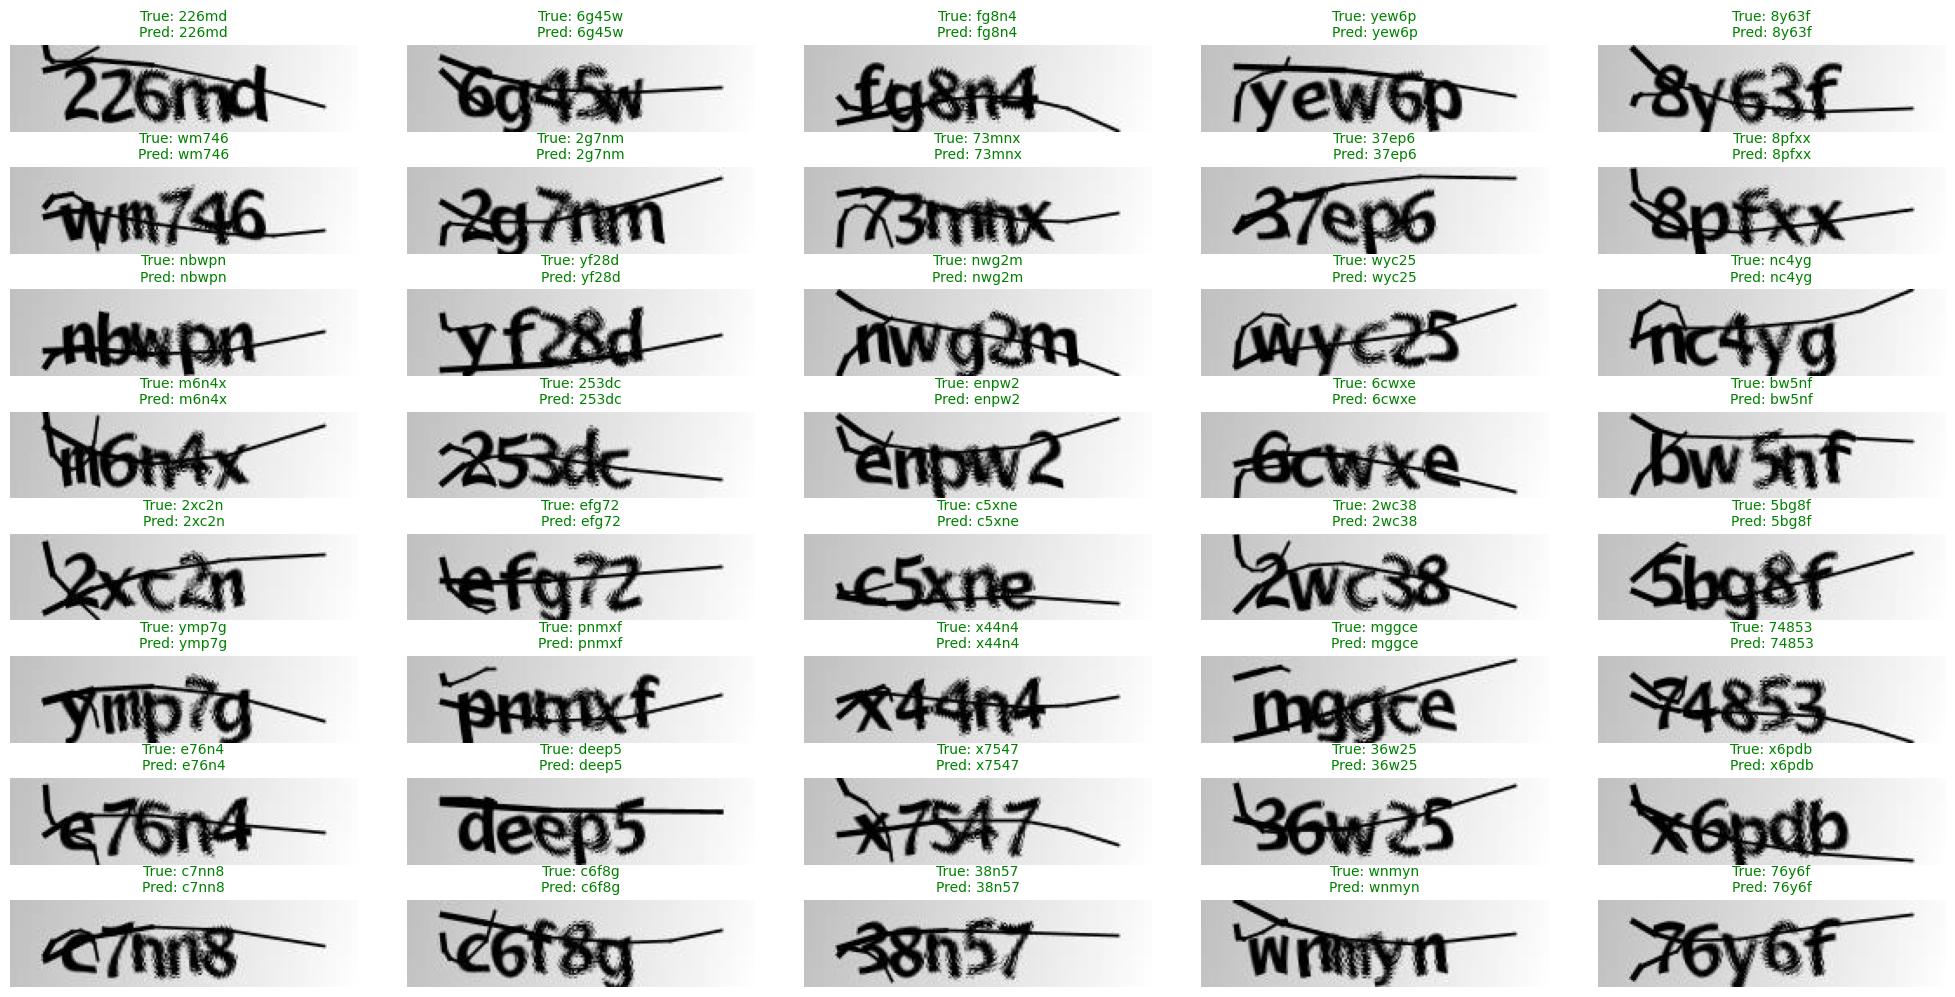

In [28]:
# Let's check results on some validation samples
preds = prediction_ctc_model.predict(X_test[:40])
pred_texts = decode_batch_predictions(preds)

plt.figure(figsize=(20, 10))
correct_predictions = 0
total_chars = len(pred_texts) * 5
complete_correct = 0

for i in range(len(pred_texts)):
    # Get the predicted and true texts
    pred_text = pred_texts[i]
    true_text = labels_test[i]

    # Count correct characters and complete matches
    correct_predictions += sum(1 for p, t in zip(pred_text, true_text) if p == t)
    if pred_text == true_text:
        complete_correct += 1

    # Display the image and prediction
    plt.subplot(8, 5, i + 1)
    plt.imshow(X_test[i].T.squeeze(), cmap="gray")
    plt.title(
        f"True: {true_text}\nPred: {pred_text}",
        color="green" if pred_text == true_text else "red",
        fontsize=10,
    )
    plt.axis("off")

# Show accuracy metrics
ctc_a = correct_predictions / total_chars
print(f"Character-level accuracy: {ctc_a:.2%}")
ctc_cr = complete_correct / len(pred_texts)
print(f"Complete captcha success rate: {ctc_cr:.2%}")
plt.tight_layout()
plt.show()

# Multiple (5) outputs of sizes 1

In [29]:
def create_branch_model(img_shape=(200, 50, 1), num_symbols=36):
    # Input layer
    img = layers.Input(shape=img_shape)  # Input image

    # Convolutional backbone
    conv1 = layers.Conv2D(16, (3, 3), padding="same", activation="relu")(img)
    mp1 = layers.MaxPooling2D(padding="same")(conv1)

    conv2 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(mp1)
    mp2 = layers.MaxPooling2D(padding="same")(conv2)

    conv3 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding="same")(bn)

    # Flatten the output
    flat = layers.Flatten()(mp3)  # Flatten to 1D vector

    # Create 5 branches for character prediction
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation="relu")(flat)  # Fully connected layer
        drop = layers.Dropout(0.5)(dens1)  # Dropout for regularization
        res = layers.Dense(num_symbols, activation="softmax")(
            drop
        )  # Character prediction
        outs.append(res)

    # Define the model
    model = models.Model(img, outs)

    # Compile the model
    model.compile(
        loss="categorical_crossentropy",  # Loss for each branch
        optimizer="adam",  # Optimizer
        metrics=5 * ["accuracy"],  # Accuracy for each branch
    )

    return model


# Create the model
branch_model = create_branch_model()
branch_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200, 50,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 200, 50,   │        160 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 100, 25,   │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 100, 25,   │      4,640 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 50, 13,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 50, 13,    │      9,248 │ max_pooling2d_17… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 13,    │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 25, 7, 32) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 5600)      │          0 │ max_pooling2d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │    358,464 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │    358,464 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │    358,464 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │    358,464 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │    358,464 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 36)        │      2,340 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 36)        │      2,340 │ dropout_5[0][0] 

 Total params: 1,818,196 (6.94 MB)

 Trainable params: 1,818,132 (6.94 MB)

 Non-trainable params: 64 (256.00 B)

In [30]:
# Train the model
history = branch_model.fit(
    X_train,
    [y_train[:, i, :] for i in range(5)],
    validation_data=(X_val, [y_val[:, i, :] for i in range(5)]),
    epochs=nb_epoch,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - dense_11_accuracy: 0.0512 - dense_11_loss: 3.8534 - dense_13_accuracy: 0.0507 - dense_13_loss: 3.7662 - dense_15_accuracy: 0.0497 - dense_15_loss: 3.6836 - dense_17_accuracy: 0.0377 - dense_17_loss: 3.7451 - dense_9_accuracy: 0.0573 - dense_9_loss: 3.7369 - loss: 18.7856 - val_dense_11_accuracy: 0.0189 - val_dense_11_loss: 3.5439 - val_dense_13_accuracy: 0.0943 - val_dense_13_loss: 3.4254 - val_dense_15_accuracy: 0.0566 - val_dense_15_loss: 3.5419 - val_dense_17_accuracy: 0.0566 - val_dense_17_loss: 3.4844 - val_dense_9_accuracy: 0.0189 - val_dense_9_loss: 3.5323 - val_loss: 17.5250
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - dense_11_accuracy: 0.0754 - dense_11_loss: 3.4577 - dense_13_accuracy: 0.0658 - dense_13_loss: 3.2593 - dense_15_accuracy: 0.1132 - dense_15_loss: 3.5065 - dense_17_accuracy: 0.0839 - dense_17_loss: 3.4169 - dense_9_accuracy: 0.0693 - dense_9_loss: 3.3965 - loss: 17.0367 - val_dense_11_accuracy: 0.1698 

Character-level accuracy: 81.00%
Complete captcha success rate: 50.00%


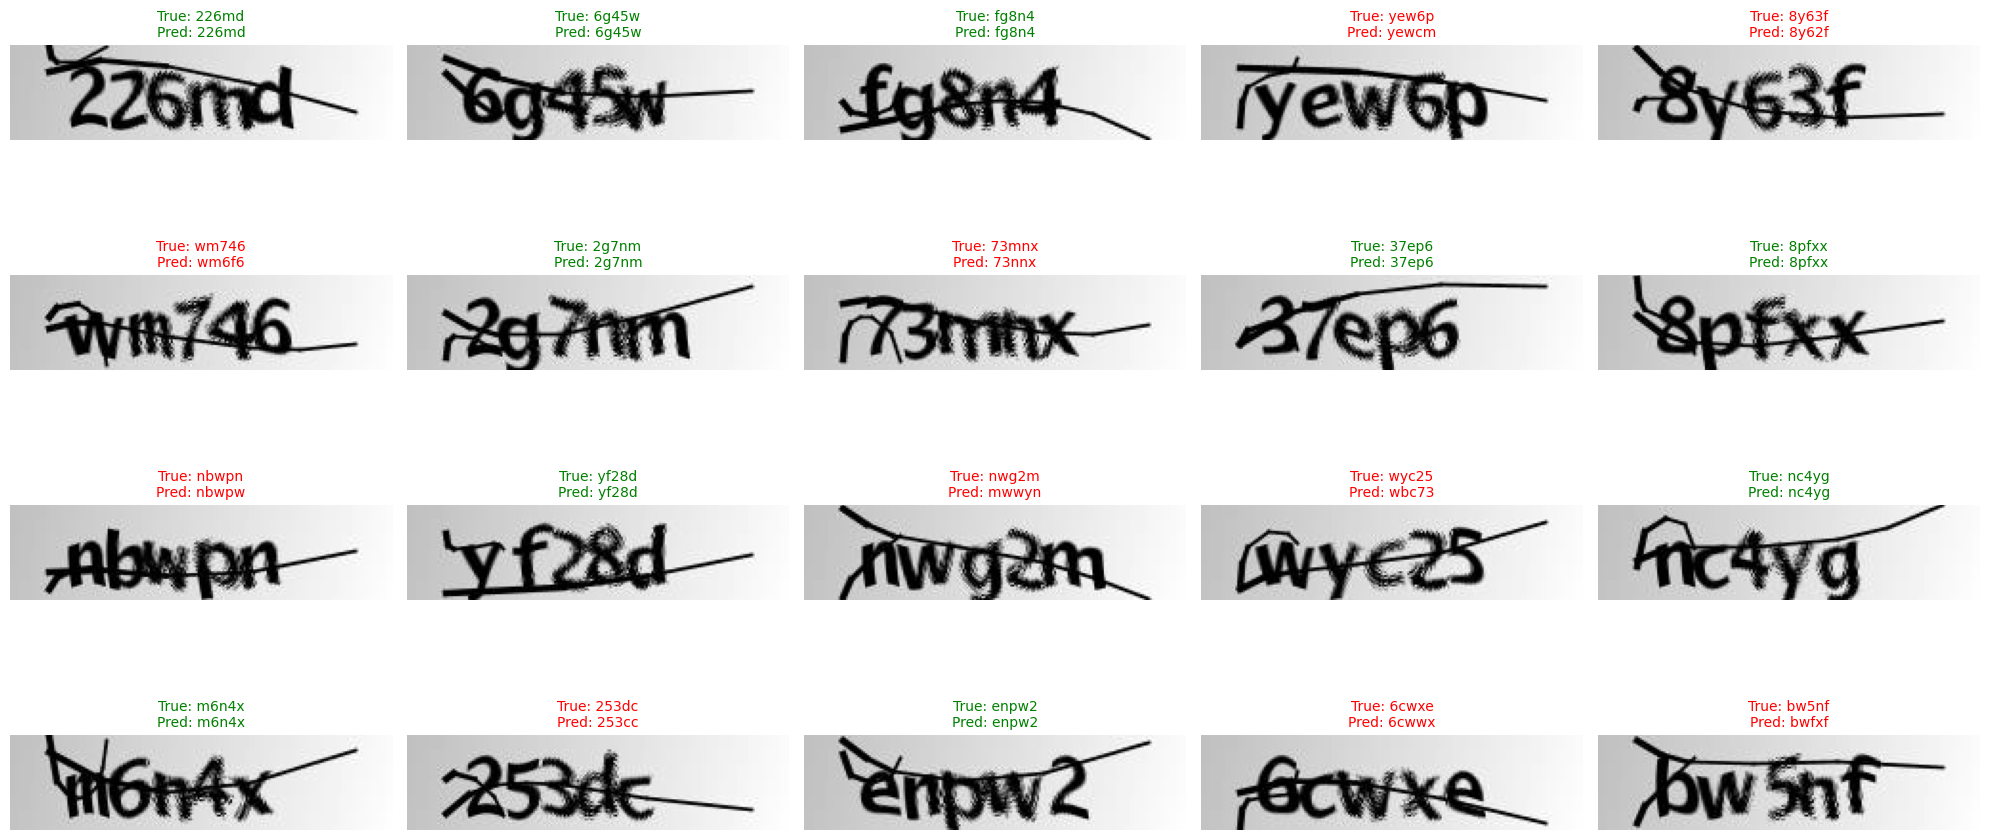

In [31]:
# Evaluate the model
branch_a, branch_cr = evaluate_predictions_multi_output(
    branch_model, X_test, y_test, symbols
)

# Performances Analysis

___

                Model  Character Accuracy (%)  Full Captcha Success Rate (%)
0                 CNN                      76                             20
1            CNN+LSTM                       7                              0
2                CRNN                      39                              0
3         Transformer                      36                              0
4  CNN with Attention                      51                              0
5                 CTC                     100                            100
6    Multiple Outputs                      81                             50


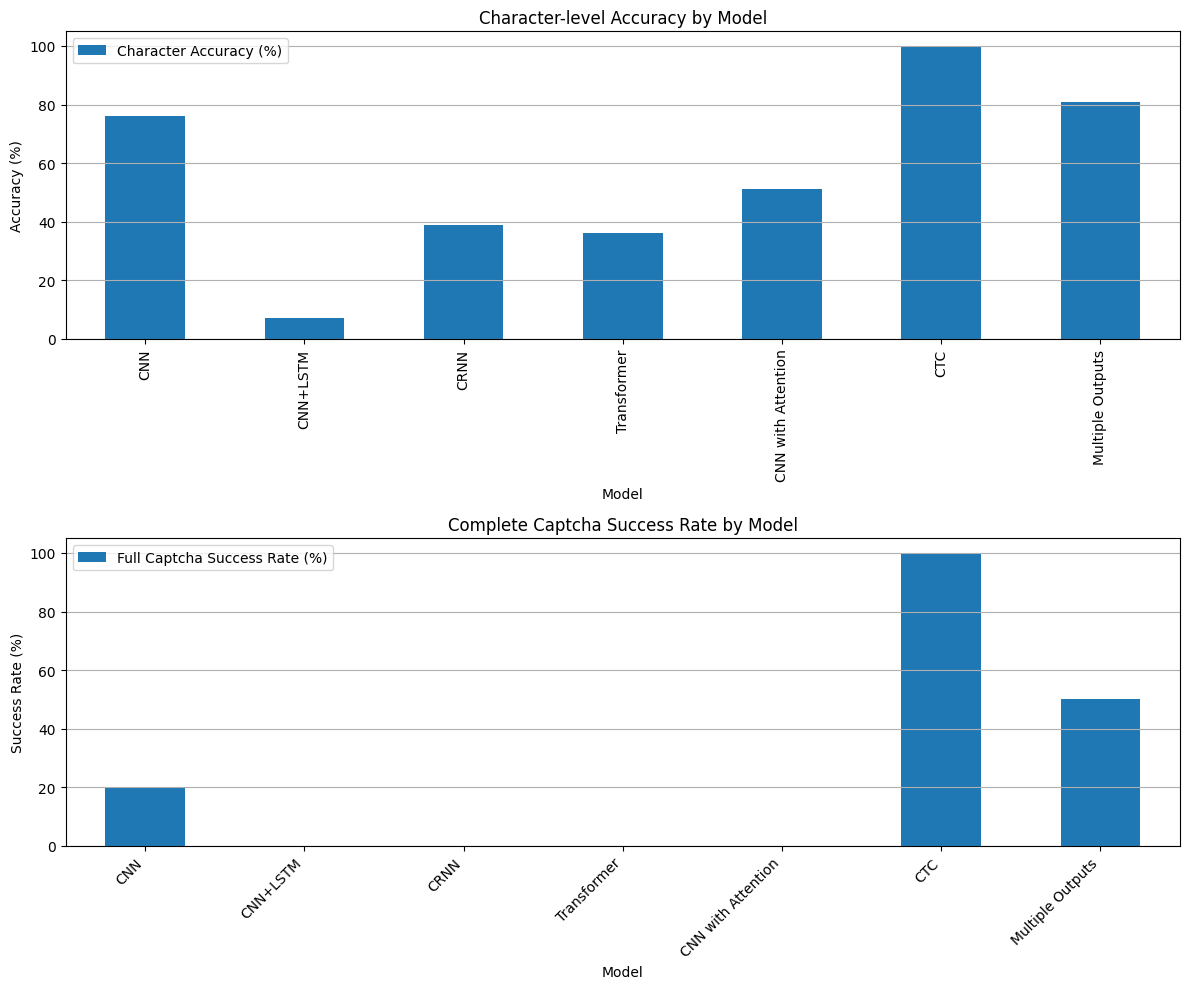

In [41]:
# Data for the table
data = {
    "Model": [
        "CNN",
        "CNN+LSTM",
        "CRNN",
        "Transformer",
        "CNN with Attention",
        "CTC",
        "Multiple Outputs",
    ],
    "Character Accuracy (%)": [
        int(cnn_a * 100),
        int(cnn_lstm_a * 100),
        int(crnn_a * 100),
        int(transformer_a * 100),
        int(att_cnn_a * 100),
        int(ctc_a * 100),
        int(branch_a * 100),
    ],
    "Full Captcha Success Rate (%)": [
        int(cnn_cr * 100),
        int(cnn_lstm_cr * 100),
        int(crnn_cr * 100),
        int(transformer_cr * 100),
        int(att_cnn_cr * 100),
        int(ctc_cr * 100),
        int(branch_cr * 100),
    ],
}

# Create DataFrame
df_comparison = pd.DataFrame(data)

# Display the table
print(df_comparison)

# Create bar plots to visualize the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Character-level Accuracy
df_comparison.plot(x="Model", y="Character Accuracy (%)", kind="bar", ax=ax1)
ax1.set_title("Character-level Accuracy by Model")
ax1.set_ylabel("Accuracy (%)")
ax1.grid(True, axis="y")

# Plot Complete Captcha Success Rate
df_comparison.plot(x="Model", y="Full Captcha Success Rate (%)", kind="bar", ax=ax2)
ax2.set_title("Complete Captcha Success Rate by Model")
ax2.set_ylabel("Success Rate (%)")
ax2.grid(True, axis="y")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Model performances

Here are the results for each model on captcha recognition:

| Model                  | Character Accuracy (%) | Full Captcha Success Rate (%) |
|------------------------|------------------------|-------------------------------|
| CNN                    | 76                     | 20                            |
| CNN+LSTM               | 7                      | 0                             |
| CRNN                   | 39                     | 0                             |
| Transformer            | 36                     | 0                             |
| CNN with Attention     | 51                     | 0                             |
| CTC                    | 100                    | 100                           |
| Multiple Outputs       | 81                     | 50                            |

## Results analysis

1. **CNN (Convolutional Neural Network)**:
   The CNN model performs reasonably well on individual character recognition but struggles with recognizing the entire captcha correctly. This is likely because CNNs are good at spatial feature extraction but do not inherently handle sequence information well, which is crucial for captcha recognition.

2. **CNN+LSTM (Convolutional Neural Network + Long Short-Term Memory)**:
   This combination performs poorly indicating that the model requires further tuning. LSTMs are designed to handle sequence data, but the integration with CNN might not be optimal, leading to poor performance.

3. **CRNN (Convolutional Recurrent Neural Network)**:
   The CRNN model has moderate character accuracy but fails to recognize any full captchas correctly, suggesting issues with sequence learning. While CRNNs combine CNNs for feature extraction and RNNs for sequence learning, the model might not be sufficiently trained or tuned for the complexity of captcha sequences.

4. **Transformer**:
   The Transformer model shows similar performance to CRNN, with moderate character accuracy but no success in full captcha recognition. Transformers are powerful for sequence-to-sequence tasks but require large amounts of data and computational resources to train effectively, which might not have been available. Also, we didn't get far on tuning this one since it took a lot of time to implement everything.

5. **CNN with Attention**:
   Adding attention to CNN improves character accuracy but still fails to recognize full captchas, indicating that attention helps but is not sufficient alone. Attention mechanisms help the model focus on relevant parts of the input, but without sequence modeling, it struggles with the overall captcha recognition.

6. **CTC (Connectionist Temporal Classification)**:
   The CTC model excels in both character accuracy and full captcha success rate, making it the best-performing model for this task. CTC is designed to handle sequence alignment and is particularly effective for tasks like captcha recognition where the length of the output sequence can vary.

7. **Multiple Outputs**:
   This model performs well, with high character accuracy and a decent full captcha success rate, indicating a good balance between recognizing individual characters and entire sequences. The multiple output branches allows the model to treat each character independently, also it gives it flexibility to localise and capture the surrounding of each character.

These results suggest that models designed to handle sequence learning and alignment, like CTC, are particularly effective for captcha recognition tasks. We didn't have the time to fully tune all models; the goal here was to show the different models that exist to answer the Captcha problem and that it is indeed not an easy task to get the full captcha text as it was designed to complicate this task.  
However, we can see that with some more advanced models (multibranches CNN / CNN-RNN combined with CTC loss function), it becomes possible.

Today, CAPTCHAs continue to evolve, incorporating more sophisticated techniques to stay ahead of automated systems. The goal remains the same: to ensure that the user is a human and not a bot, but the methods have become more advanced and varied.